# How to use CLIPModel and fine tune it

In [1]:
import os
import sys

import clip

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

module_path = os.path.join(os.getcwd(), '../src')
sys.path.append(module_path)

from gan_t2i.datasets.DatasetFactory import DatasetFactory
from gan_t2i.models.CLIP import CLIPModel

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" 
Uncomment if you want to compute the mean and the standard deviation
"""
if False:
    dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Calcolare media e deviazione standard
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for images, _, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    print("mean: ", mean, "\nstd: ", std)

In [3]:
""" Image transformations """
transform_img = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    
    # Previously computed mean and std
    transforms.Normalize([0.4355, 0.3777, 0.2879], [0.2571, 0.2028, 0.2101])
])

In [4]:
""" Text Transformation

You need to tokenize your text before passing it to the model.
"""
def tokenize_text(text):
    
    # Try except is needed due to error thrown by CLIP model that limit the context size
    # to 77 tokens so we need to split the text in smaller chunks and keep only a small portion
    # of it if the text is too long
    try:
        return clip.tokenize([text])[0]
    except:
        return clip.tokenize([text.split(".")[0]])[0]    
    

In [5]:
dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transform_img, transform_caption=tokenize_text)

Captions already downloaded
images already downloaded
Captions already extracted
images already extracted
The dataset is already stored in HDF5 format


In [6]:
# Create train, validation and test set     NOTE: We are using small subset of the dataset for this example
train_size = int(0.05 * len(dataset))
val_size = int(0.02 * len(dataset))
test_size = int(0.02 * len(dataset))

# Cration of train, validation and test set indices and samplers
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, train_size + val_size + test_size))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Creation of train, validation and test dataloaders
train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(dataset, batch_size=64, sampler=test_sampler, pin_memory=True)

In [7]:
model = CLIPModel() # by default load ViT-B/32

Used device: cuda


In [8]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints")
log_path = os.path.join(os.getcwd(), "logs")

In [10]:
model.fit( 
    train_dataloader = train_loader, 
    val_dataloader = val_loader,
    num_epochs = 3, 
    save_path=checkpoints_path
    )

  0%|          | 0/64 [00:00<?, ?it/s]c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
	=> Validation: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]


Epoch [1/3] Summary:
	=> Train Loss: 3.260193
	=> Val Loss: 3.351037



	=> Validation: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s]


Epoch [2/3] Summary:
	=> Train Loss: 2.681030
	=> Val Loss: 3.341572



	=> Validation: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s]


Epoch [3/3] Summary:
	=> Train Loss: 2.451385
	=> Val Loss: 3.278696



Plot the metrics saved by the default csv logger

In [15]:
csv_filename = "metrics.csv"
csv_path = os.path.join(log_path, "CLIPModel", "version_0", csv_filename)

metrics = pd.read_csv(csv_path) 

In [16]:
display(metrics)

,epoch,iteration,loss,step,train_loss,val_loss
0,NaN,1.0,3.660156,0,NaN,NaN
1,NaN,2.0,4.648438,1,NaN,NaN
2,NaN,3.0,4.265625,2,NaN,NaN
3,NaN,4.0,4.117188,3,NaN,NaN
4,NaN,5.0,4.105469,4,NaN,NaN
...,...,...,...,...,...,...
190,NaN,189.0,2.527344,188,NaN,NaN
191,NaN,190.0,2.353516,189,NaN,NaN
192,NaN,191.0,2.414062,190,NaN,NaN
193,NaN,192.0,2.335938,191,NaN,NaN


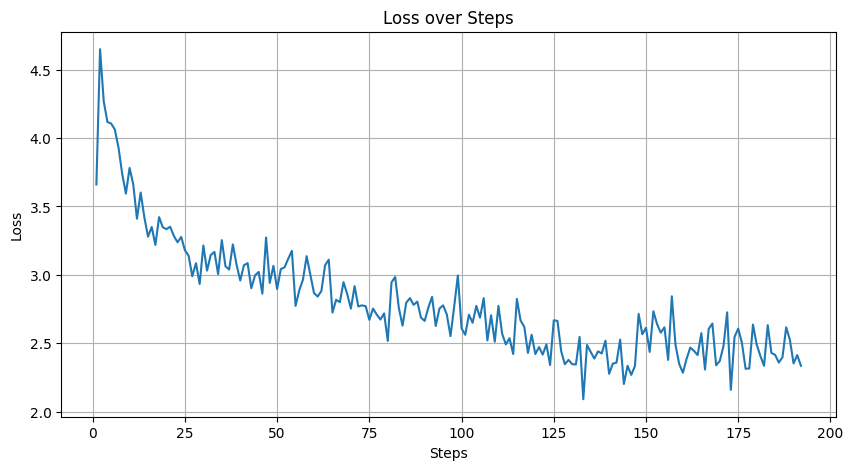

In [29]:
steps = metrics["iteration"].dropna().to_numpy()
losses = metrics["loss"].dropna().to_numpy()

plt.figure(figsize=(10,5))
plt.plot(steps, losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss over Steps")
plt.grid()
plt.show()

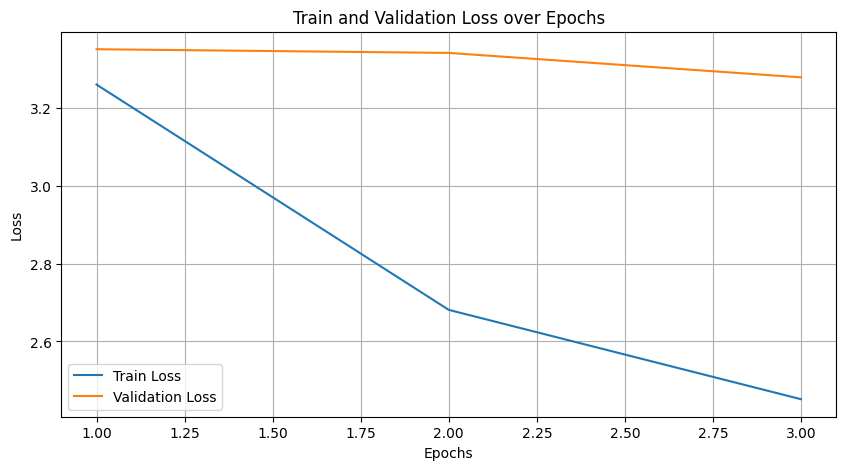

In [32]:
epochs = metrics["epoch"].dropna().to_numpy()
tr_losses = metrics["train_loss"].dropna().to_numpy()
val_losses = metrics["val_loss"].dropna().to_numpy()

plt.figure(figsize=(10,5))
plt.plot(epochs, tr_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid()
plt.show()

Load the checkpoint created at the end of epoch w

In [33]:
checkpoint = torch.load(os.path.join(checkpoints_path, "CLIPModel_epoch-2.pt"))
loaded_model = CLIPModel()
loaded_model.load_state_dict(checkpoint['model_state_dict'])

Used device: cuda


<All keys matched successfully>

In [39]:
from gan_t2i.models.CLIP import ContrastiveLoss

total_test_loss = 0.0
for images, captions, _ in test_loader:
    with torch.no_grad():
        images = images.to("cuda" if torch.cuda.is_available() else "cpu")
        captions = captions.to("cuda" if torch.cuda.is_available() else "cpu")

        # Get the image and text features
        image_features = loaded_model.encode_image(images)
        text_features = loaded_model.encode_text(captions)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        ground_truth = torch.arange(len(images)).to("cuda" if torch.cuda.is_available() else "cpu")
        total_test_loss += ContrastiveLoss(image_features, text_features).item()
    
print("Total test loss: ", total_test_loss / len(test_loader))

Total test loss:  3.5555889423076925
